# Perkenalan

data yang digunakan merupakan dataset cuaca yang khusus digunakan untuk image classification dengan [source data berikut](https://data.mendeley.com/datasets/4drtyfjtfy/1?ref=hackernoon.com).

> Tujuan dari milestone ini adalh untuk membuat sebuah model dengan akurasi tinggi dengn menggunkan bsae model dan praktik atas transfer learning dari VGG16 

# Library

In [1]:
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import imageio
%matplotlib inline
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Data Loading

In [2]:
train_folder=r'data/train'
val_folder=r'data/val'
test_folder=r'data/test'

> data dipisaahka ke dalaam folder masing masing setiap kelas dengan proporsi 70:20:10 

In [3]:
import pathlib
data_dir = pathlib.Path(train_folder)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

787


> Total data train yang digunakan sejumlah 787 gambar

## Penentuan dataset dan ukuran file yang akan di train

In [4]:
IMG_WIDTH=317
IMG_HEIGHT=167
IMG_SIZE=(IMG_HEIGHT, IMG_WIDTH)
batch_size=4

konsideran :
* ukuran file akan di resize menjadi 317x167 untuk keseragaman seluruh dataset dan mempersingkat waktu train
* jumbal batch_size 4 dinilai telah optimal sesuai dengan size dari data train

In [5]:
train_dataset = image_dataset_from_directory(
    train_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=IMG_SIZE
    )

Found 787 files belonging to 4 classes.


In [6]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  val_folder,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 225 files belonging to 4 classes.


# Eksplorasi Data

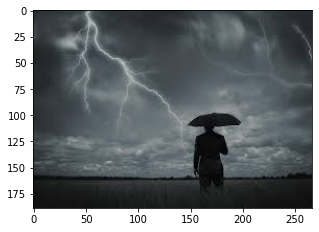

In [7]:
pic = imageio.imread('data/train/cloudy/cloudy65.jpg')
plt.figure(figsize = (5,5))
plt.imshow(pic)

In [8]:
print('Tipe data : ' , type(pic)) 
print('Image Shape : {}'.format(pic.shape)) 
print('Image Hight : {}'.format(pic.shape[0])) 
print('Image Width : {}'.format(pic.shape[1])) 
print('Dimension : {}'.format(pic.ndim))

Tipe data :  <class 'imageio.core.util.Array'>
Image Shape : (189, 267, 3)
Image Hight : 189
Image Width : 267
Dimension : 3


> berikut informasi dasar dari dataset yang digunakan

# Data Preprocessing

In [9]:
class_names = train_dataset.class_names
print(class_names)

['cloudy', 'rain', 'snine', 'sunrise']


In [10]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 167, 317, 3)
(4,)


## Autotune data Train dan Val

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(99).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

> dilakukan proses autotune pada buffer_size untuk memastikan tidak terjadi bottleneck pada saat proses training dan validasi

## Rescale data value

In [12]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Model

## Base Model

In [14]:
keras.backend.clear_session()

In [15]:
np.random.seed(69)
tf.random.set_seed(69)

### Data Augmentation layer

In [17]:
img_aug = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

> layer imaage augmentation ini aakan di berikan kepada seluruh model, dikarenakan tidak adanya proses shuffling ulang atau data baru pada data train dan validation, maka image augmenntation diberlakukan sama pada setiap model 

In [18]:
num_classes = 4

model = Sequential([
    img_aug,
    layers.InputLayer(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

Pertimbangan pemilihan Activation :
* Relu dipilih dikarenakan performance yang cepat secara komputasi (faktor utama) dan terbukti baik dalam mengelola segala jenis dataset
* dilakukan pemilihn neuron kelipaatan 2 dengan dimulai dari 16 dengan menggunakan 3 dimensi (RGB) dari masing masing daataset
* untuk menghindari overfitting diberlakukan dropout pada layer terakhir

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Pertimbangan pemilihan optimizer :
* Adam dipilih dikarenakan proses komputasi yang relatif efisien dengan learning rate 0.0001 agar dapat menekan loss pada saat proses learning
* loss function yang dipilih adalah SparseCategoricalCrossentropy dikarenakan target multi label (4 class), from logits di set menjadi true agar dapat terbaca sebagai logit tensor dan bukan angka distribusi probabilitas

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 167, 317, 3)       0         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              (None, 167, 317, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 83, 158, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 83, 158, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 79, 64)       

### Setup Early Stoping

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)

> early stopping dipilih 20 (10% dari angka total epoch) agar memberikan ruang kepada model untuk memberikan gambaran fluktuasi haasil train per epoch, tujuannya agar dapat terlihat performanace asli dari dataset untuk mendapatkan model yang robust

In [22]:
epochs=200

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[es],
)

Epoch 1/200
197/197 [==============================] - 6s 17ms/step - loss: 17.1442 - accuracy: 0.5909 - val_loss: 3.1342 - val_accuracy: 0.7022
Epoch 2/200
197/197 [==============================] - 3s 15ms/step - loss: 1.2466 - accuracy: 0.7497 - val_loss: 0.9632 - val_accuracy: 0.7689
Epoch 3/200
197/197 [==============================] - 3s 15ms/step - loss: 0.7794 - accuracy: 0.7522 - val_loss: 0.5073 - val_accuracy: 0.8222
Epoch 4/200
197/197 [==============================] - 3s 15ms/step - loss: 0.5447 - accuracy: 0.8208 - val_loss: 0.4775 - val_accuracy: 0.8222
Epoch 5/200
197/197 [==============================] - 3s 15ms/step - loss: 0.5036 - accuracy: 0.8386 - val_loss: 0.6865 - val_accuracy: 0.7867
Epoch 6/200
197/197 [==============================] - 3s 15ms/step - loss: 0.5209 - accuracy: 0.8208 - val_loss: 0.4449 - val_accuracy: 0.8667
Epoch 7/200
197/197 [==============================] - 3s 15ms/step - loss: 0.4304 - accuracy: 0.8412 - val_loss: 0.3916 - val_accuracy

## Base Model Evaluation

### Classification report Matrix

In [23]:
from sklearn.metrics import classification_report

In [24]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_folder, # Put your path here
     target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=4,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 113 images belonging to 4 classes.


In [25]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [26]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

      cloudy       0.86      0.83      0.85        30
        rain       0.84      0.95      0.89        22
       shine       0.95      0.84      0.89        25
     sunrise       0.95      0.97      0.96        36

    accuracy                           0.90       113
   macro avg       0.90      0.90      0.90       113
weighted avg       0.90      0.90      0.90       113



Kesimpulan base model
 > Akurasi dari base model dinilai cukup bagus dengan f1 score diatas 85 untuk masing masing kelas


### Result Per Epoch

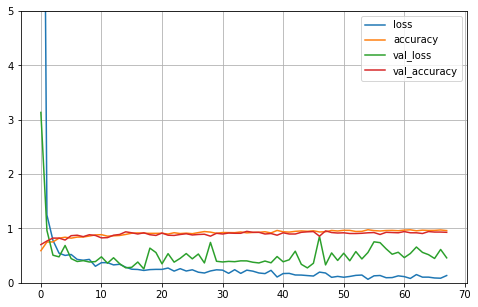

In [27]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca(),plt.ylim(0, 5)
plt.show()

> loss padaa validasi  maasih menunjukan skor yaang tinggi menandakan model masih belum cukup baik dalam melakukan prediksi walaupunn antar class telah memberikan akurasi yang cukup baik 

## Model Inference Base Model

### Fungsi untuk model inference

In [28]:
def pred_infer(image, img_height, img_width):
    img = keras.preprocessing.image.load_img(image, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predict = model.predict(img_array)
    score = tf.nn.softmax(predict[0])
    print(f"Kayaknya hasilnya {class_names[np.argmax(score)]} persentasenya {np.max(score) * 100} %")
    return img

Kayaknya hasilnya rain persentasenya 99.55099821090698 %


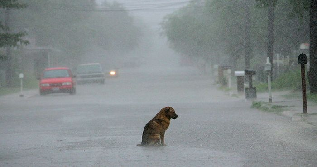

In [29]:
pred_infer('inference/inference/doginrain.jpg',IMG_HEIGHT, IMG_WIDTH)

## Transfer Learning with VGG16

In [30]:
keras.backend.clear_session()

In [31]:
np.random.seed(69)
tf.random.set_seed(69)

In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

## Data Preprocessing

In [33]:
train_dataset = image_dataset_from_directory(
    train_folder,
    shuffle=True,
    batch_size=batch_size,
    image_size=IMG_SIZE
    )

Found 787 files belonging to 4 classes.


In [34]:
train_dataset

<BatchDataset shapes: ((None, 167, 317, 3), (None,)), types: (tf.float32, tf.int32)>

In [36]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  val_folder,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 225 files belonging to 4 classes.


In [37]:
val_dataset

<BatchDataset shapes: ((None, 167, 317, 3), (None,)), types: (tf.float32, tf.int32)>

In [38]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5)
val_dataset = val_dataset.skip(val_batches // 5)

In [39]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 46
Number of test batches: 11


In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

In [41]:
train_dataset

<PrefetchDataset shapes: ((None, 167, 317, 3), (None,)), types: (tf.float32, tf.int32)>

### Image Augmentation

In [43]:
img_aug = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [44]:
IMG_SHAPE = IMG_SIZE + (3,)

In [45]:
IMG_SHAPE

(167, 317, 3)

In [46]:
model_vgg16 = VGG16(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

> Base Model VGG16 dengan weight imagenet

In [47]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model_vgg16(image_batch)
print(feature_batch.shape)

(4, 5, 9, 512)


In [48]:
model_vgg16.trainable = False

In [49]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 167, 317, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 167, 317, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 167, 317, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 83, 158, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 83, 158, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 83, 158, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 41, 79, 128)       0     

In [50]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = img_aug(inputs)
x = model_vgg16(x, training=False)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(4)(x)
model = tf.keras.Model(inputs, outputs)

> tambahan base model setelah layer VGG16 untuk proses transfer learning

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 167, 317, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 167, 317, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 9, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 9, 16)          73744     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 5, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 5, 32)          4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 3, 32)          0     

In [53]:
len(model.trainable_variables)

10

In [54]:
val_dataset

<PrefetchDataset shapes: ((None, 167, 317, 3), (None,)), types: (tf.float32, tf.int32)>

In [55]:
initial_epochs = 200

loss0, accuracy0 = model.evaluate(val_dataset)

46/46 [==============================] - 3s 30ms/step - loss: 2.6613 - accuracy: 0.2431


In [56]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.66
initial accuracy: 0.24


In [57]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)


In [58]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset,
                    callbacks=[es],)

Epoch 1/200
197/197 [==============================] - 9s 37ms/step - loss: 1.5125 - accuracy: 0.3977 - val_loss: 0.8485 - val_accuracy: 0.6630
Epoch 2/200
197/197 [==============================] - 7s 34ms/step - loss: 0.9008 - accuracy: 0.6468 - val_loss: 0.6601 - val_accuracy: 0.7293
Epoch 3/200
197/197 [==============================] - 7s 34ms/step - loss: 0.5925 - accuracy: 0.7789 - val_loss: 0.3456 - val_accuracy: 0.8564
Epoch 4/200
197/197 [==============================] - 7s 34ms/step - loss: 0.4057 - accuracy: 0.8551 - val_loss: 0.3278 - val_accuracy: 0.9006
Epoch 5/200
197/197 [==============================] - 7s 34ms/step - loss: 0.2947 - accuracy: 0.8996 - val_loss: 0.2869 - val_accuracy: 0.9006
Epoch 6/200
197/197 [==============================] - 7s 35ms/step - loss: 0.2538 - accuracy: 0.9123 - val_loss: 0.3214 - val_accuracy: 0.8785
Epoch 7/200
197/197 [==============================] - 7s 34ms/step - loss: 0.2146 - accuracy: 0.9212 - val_loss: 0.1921 - val_accuracy:

## Classification report Base Model + VGG16

In [60]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_folder, # Put your path here
     target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=4,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 113 images belonging to 4 classes.


In [61]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [62]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

      cloudy       0.91      1.00      0.95        30
        rain       1.00      1.00      1.00        22
       shine       0.95      0.84      0.89        25
     sunrise       0.97      0.97      0.97        36

    accuracy                           0.96       113
   macro avg       0.96      0.95      0.95       113
weighted avg       0.96      0.96      0.95       113



## Result Per Epoch

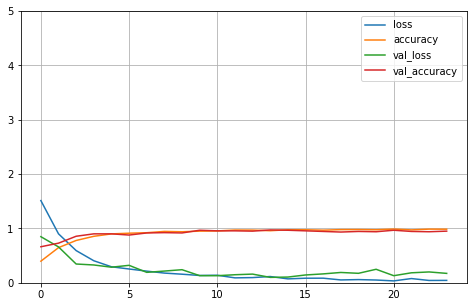

In [63]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca(),plt.ylim(0, 5)
plt.show()

## Model Inference

In [65]:
def pred_infer(image, img_height, img_width):
    img = keras.preprocessing.image.load_img(image, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predict = model.predict(img_array)
    score = tf.nn.softmax(predict[0])
    print(f"Kayaknya hasilnya {class_names[np.argmax(score)]} persentasenya {np.max(score) * 100} %")
    return img

Kayaknya hasilnya rain persentasenya 100.0 %


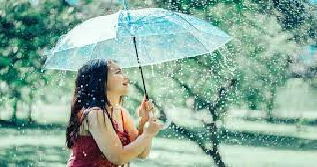

In [68]:
pred_infer('inference/inference/mbakmbak.jpg',IMG_HEIGHT, IMG_WIDTH)

# Model Improvement

## Model VGG16 with fine-tuning

In [69]:
print("Number of layers in the base model: ", len(model_vgg16.layers))

Number of layers in the base model:  19


In [70]:
fine_tune_at = 10
for layer in model_vgg16.layers[:fine_tune_at]:
  layer.trainable =  False

In [71]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

In [72]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 167, 317, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 167, 317, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 9, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 9, 16)          73744     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 5, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 5, 32)          4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 3, 32)          0     

In [73]:
len(model.trainable_variables)

10

In [74]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset,
                         callbacks=[es],)

Epoch 24/210
197/197 [==============================] - 9s 36ms/step - loss: 0.0963 - accuracy: 0.9682 - val_loss: 0.1717 - val_accuracy: 0.9613
Epoch 25/210
197/197 [==============================] - 7s 35ms/step - loss: 0.0877 - accuracy: 0.9657 - val_loss: 0.2656 - val_accuracy: 0.9337
Epoch 26/210
197/197 [==============================] - 7s 37ms/step - loss: 0.0502 - accuracy: 0.9822 - val_loss: 0.2533 - val_accuracy: 0.9392
Epoch 27/210
197/197 [==============================] - 7s 36ms/step - loss: 0.0725 - accuracy: 0.9771 - val_loss: 0.2533 - val_accuracy: 0.9392
Epoch 28/210
197/197 [==============================] - 7s 36ms/step - loss: 0.0562 - accuracy: 0.9835 - val_loss: 0.1911 - val_accuracy: 0.9503
Epoch 29/210
197/197 [==============================] - 8s 39ms/step - loss: 0.0550 - accuracy: 0.9848 - val_loss: 0.2554 - val_accuracy: 0.9503
Epoch 30/210
197/197 [==============================] - 8s 38ms/step - loss: 0.0660 - accuracy: 0.9746 - val_loss: 0.1743 - val_ac

## Classification Report Base Model + VGG16 and fine tuning

In [76]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    test_folder, # Put your path here
     target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=4,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 113 images belonging to 4 classes.


In [77]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [78]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

      cloudy       0.94      1.00      0.97        30
        rain       1.00      1.00      1.00        22
       shine       0.96      0.88      0.92        25
     sunrise       0.97      0.97      0.97        36

    accuracy                           0.96       113
   macro avg       0.97      0.96      0.96       113
weighted avg       0.96      0.96      0.96       113



## Result Per Epoch

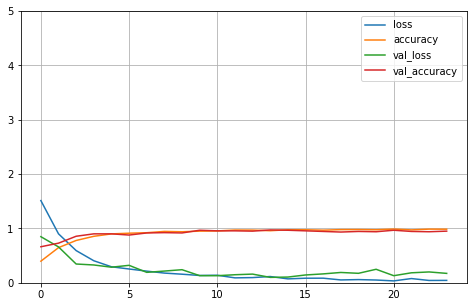

In [79]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca(),plt.ylim(0, 5)
plt.show()

## Model Inference

In [86]:
def pred_infer(image, img_height, img_width):
    img = keras.preprocessing.image.load_img(image, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predict = model.predict(img_array)
    score = tf.nn.softmax(predict[0])
    print(f"Kayaknya hasilnya {class_names[np.argmax(score)]} persentasenya {np.max(score) * 100} %")
    return img

Kayaknya hasilnya snine persentasenya 64.55250382423401 %


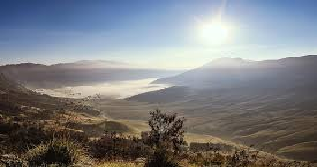

In [89]:
pred_infer('inference/inference/bromo.jpg',IMG_HEIGHT, IMG_WIDTH)

# Kesimpulan 

## Data Analysist

> Data yaang diberikan untuk train model telah memberikan kejelasan yang cukup baik dari masing masing kelas, sehingga memberikan skor yang cukup tinggi pada masing masing kelas ketika dilakukan validasi dan model inference

## Model Analysist

### Base Model

> Base model dinilai telah memberikan hasil yang cukup memuaskan, dengan pemilihan neuron dan activation function yang general (relu) dinilai telah cukup memberikan hasil yang baik dikarenakan dataset per kelas telah memberikan keterwakilan yang baik serga data yang cukup heterogen antar kelasnya
> Untuk peningkatan dapat dilakukan pemilihan activation function yang lebih spesifik seperti Leaky Relu atau Parameterised Relu, namun tidak dilakukan karena hasil dinilai telah cukup memuaskan

### Base Model dengan TransferLearning dari VGG16

> VGG16 merupakan salah satu pretrained model dari dengan arsitektur yang sangat advance, dengan rata rata skor pada imagenet sebesar 92%, informasi yang transfer dari model tersebut telah membawa dampak sangat signifikan terhadap basemodel.

nothing more to said VGG16 is a beast

### Base Model dengan TransferLearning dari VGG16 + Fine tuning

Base model dengan tambahan transfer learning serta fine tuning terhadap 10 layer pertama dari VGG16 tidak memberikan dampak begitu positif karena pada model sebelumnya dinilai telah optimal. Perubahan optimizer pun tidak memberikan dampak yg signifikan karna informasi yg diberikan oleh VGG16 telah mendominasi model

> 